# 第6部　機械学習法

## 第1章　機械学習法による時系列予測

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

# statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# sktime：予測
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error, MeanAbsoluteError,
    mean_absolute_percentage_error, mean_absolute_error
)

# sktime：予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split, ExpandingWindowSplitter, ForecastingGridSearchCV
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データの変換
from sktime.transformations.series.detrend import (
    Deseasonalizer, Detrender
)
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

# sktime：パイプライン
from sktime.forecasting.compose import (
    TransformedTargetForecaster, MultiplexForecaster
)
from sktime.pipeline import make_pipeline
from sktime.transformations.compose import OptionalPassthrough

# 機械学習法
import lightgbm as lgb

# 再帰的に回帰分析を実行するための関数の読み込み
from sktime.forecasting.compose import make_reduction

# 周期性やトレンドの関する特徴量を作成
from statsmodels.tsa.deterministic import DeterministicProcess

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option('display.width', 80)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

# Warningを出力させないようにする
import warnings
warnings.filterwarnings("ignore")

### LightGBMによるオオヤマネコ個体数予測

#### オオヤマネコデータの読み込み

In [3]:
# オオヤマネコデータの読み込み
lynx = sm.datasets.get_rdataset('lynx').data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(
    start='1821-01', periods=len(lynx), freq='Y')
lynx.index = date_index

# 不要な時間ラベルの削除
lynx = lynx.drop(lynx.columns[0], axis=1)

# 結果の確認
print(lynx.head(10))

      value
1821    269
1822    321
1823    585
1824    871
1825   1475
1826   2821
1827   3928
1828   5943
1829   4950
1830   2577


In [4]:
# 参考：データの年数
len(lynx)

114

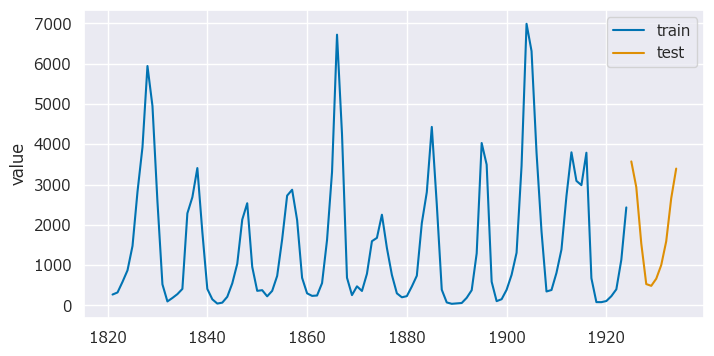

In [5]:
# 訓練データとテストデータに分割する
train_lynx, test_lynx = temporal_train_test_split(lynx, test_size=10)

# 折れ線グラフを描く
fig, ax = plot_series(train_lynx, test_lynx, 
                      labels=['train', 'test'], markers=np.tile('', 2))

# グラフサイズの指定
fig.set_size_inches(8, 4)

In [6]:
# 予測期間
fh_lynx = np.arange(1, len(test_lynx) + 1)
fh_lynx

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

#### ラグ特徴量の作成

In [7]:
# ラグデータの作成
lag = 10

lynx_lag = tsa.lagmat(
    train_lynx, maxlag=lag, original='ex', trim='both', use_pandas=True)

# 結果の確認
print(lynx_lag.head(3))

      value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1831     2577.0     4950.0     5943.0     3928.0     2821.0     1475.0   
1832      523.0     2577.0     4950.0     5943.0     3928.0     2821.0   
1833       98.0      523.0     2577.0     4950.0     5943.0     3928.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1831      871.0      585.0      321.0       269.0  
1832     1475.0      871.0      585.0       321.0  
1833     2821.0     1475.0      871.0       585.0  


In [8]:
# 結果の確認
print(train_lynx['1831':'1841'])

      value
1831    523
1832     98
1833    184
1834    279
1835    409
1836   2285
1837   2685
1838   3409
1839   1824
1840    409
1841    151


#### モデルの推定

In [9]:
# LightGBMのハイパーパラメータを設定
params = {
    'objective': 'regression',    # 回帰を目的とする
    'seed': 1,                    # 乱数の種
    'num_leaves': 20,             # 葉の数の最大値
    'learning_rate': 0.05,        # 学習率
    'n_estimators': 100,          # ブースティングの回数
    'min_data_in_leaf': 1,        # 1つの葉における最小データ数
    'verbose': -1                 # ワーニングなどの非表示
}

In [10]:
# モデル化
gbm = lgb.LGBMRegressor(**params)

# モデルの当てはめ
gbm.fit(lynx_lag, train_lynx.loc['1831':])

LGBMRegressor(learning_rate=0.05, min_data_in_leaf=1, num_leaves=20,
              objective='regression', seed=1, verbose=-1)

#### 予測

In [11]:
# テストデータの最初の値
print(test_lynx.head(1))

      value
1925   3574


In [12]:
# ラグデータの作成
lynx_lag_all = tsa.lagmat(
    lynx, maxlag=lag, original='ex', trim='both', use_pandas=True)

# 結果の確認
print(lynx_lag_all.loc['1925':'1925'])

      value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1925     2432.0     1132.0      399.0      229.0      108.0       80.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1925       81.0      674.0     3790.0      2985.0  


In [13]:
# testデータの最初の1年目を予測
gbm.predict(lynx_lag_all.loc['1925':'1925'])

array([2281.66646241])

#### 長期予測

In [14]:
# 2時点先予測に使う説明変数
x_target = lynx_lag_all.loc['1925':'1925'].copy()
x_target.iloc[:, 1:] = x_target.iloc[:, 0:9]
x_target.iloc[:, 0] = gbm.predict(lynx_lag_all.loc['1925':'1925'])[0]
print(x_target)

        value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1925  2281.666462     2432.0     1132.0      399.0      229.0      108.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1925       80.0       81.0      674.0      3790.0  


In [15]:
# 2時点先の予測
gbm.predict(x_target)

array([861.15379196])

### sktimeを用いた効率的な実装

#### モデル化と予測

In [16]:
# 予測器(LightGBM)
gbm_regressor = lgb.LGBMRegressor(**params)

In [17]:
# 再帰的にLightGBMを実行
gbm_forecaster = make_reduction(
    gbm_regressor, window_length=lag, pooling='global',strategy="recursive")

# モデルの当てはめ
gbm_forecaster.fit(train_lynx)

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.05, min_data_in_leaf=1, num_leaves=20,
              objective='regression', seed=1, verbose=-1),
                                     pooling='global')

In [18]:
# 予測の実施
print(gbm_forecaster.predict([1, 2]))

            value
1925  2281.666462
1926   861.153792


#### モデルの取得

In [19]:
mod = gbm_forecaster.get_fitted_params()['estimator']

In [20]:
mod.predict(lynx_lag_all.loc['1925':'1925'])

array([2281.66646241])

#### 長期予測結果における予測精度

In [21]:
# 長期予測の結果
pred_lynx = gbm_forecaster.predict(fh_lynx)

# 予測精度
mae = mean_absolute_error(test_lynx, pred_lynx)
mase = mean_absolute_scaled_error(
    test_lynx, pred_lynx, y_train=train_lynx)

print('MAE :', mae)
print('MASE:', mase)

MAE : 1060.9801981784228
MASE: 1.2597954972894985


### ハイパーパラメータのチューニング

In [22]:
# LightGBMのハイパーパラメータを設定
# 意図的にlearning_rateをコメントアウトした
params_2 = {
    'objective': 'regression',    # 回帰を目的とする
    'seed': 1,                    # 乱数の種
    'num_leaves': 20,             # 葉の数の最大値
#    'learning_rate': 0.05,        # 学習率
    'n_estimators': 100,          # ブースティングの回数
    'min_data_in_leaf': 1,        # 1つの葉における最小データ数
    'verbose': -1                 # ワーニングなどの非表示
}

# モデル化
gbm_sk = lgb.LGBMRegressor(**params_2)

# 再帰的にLightGBMを実行
gbm_forecaster = make_reduction(
    gbm_sk, pooling='global', strategy="recursive")

In [23]:
# ハイパーパラメータの候補
param_grid = {'window_length': np.arange(1, 20),
              'estimator__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]}

# CVの設定
cv = ExpandingWindowSplitter(fh=fh_lynx, initial_window=20, 
                             step_length=10)

# 予測器の作成
best_gbm_forecaster_lynx = ForecastingGridSearchCV(
    gbm_forecaster, strategy='refit', cv=cv, param_grid=param_grid, 
    scoring=MeanAbsoluteError()
)

# モデルの当てはめ
best_gbm_forecaster_lynx.fit(train_lynx)

# 選ばれたパラメータ
best_gbm_forecaster_lynx.best_params_

{'estimator__learning_rate': 0.07, 'window_length': 8}

In [24]:
# 予測の実施
best_gbm_pred_lynx = best_gbm_forecaster_lynx.predict(fh_lynx)

# 予測精度
mae = mean_absolute_error(test_lynx, best_gbm_pred_lynx)
mase = mean_absolute_scaled_error(
    test_lynx, best_gbm_pred_lynx, y_train=train_lynx)

print('MAE :', mae)
print('MASE:', mase)

MAE : 523.2653145686329
MASE: 0.6213191238753725


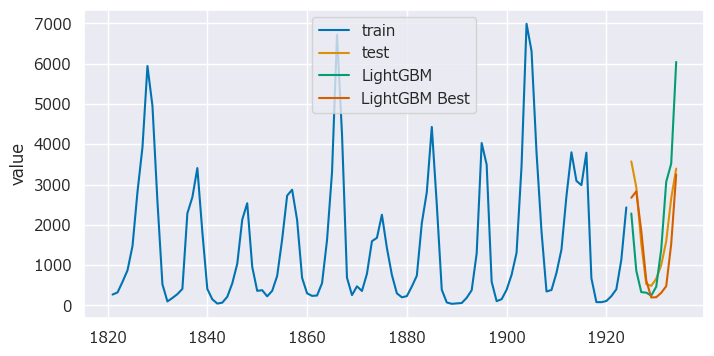

In [25]:
# 予測結果の可視化
fig, ax = plot_series(train_lynx, test_lynx, pred_lynx, best_gbm_pred_lynx,
                      labels=['train', 'test', 'LightGBM', 'LightGBM Best'], 
                      markers=np.tile('', 4))
fig.set_size_inches(8, 4)

### LightGBMによる飛行機乗客数予測

#### 飛行機乗客数データの読み込み

In [26]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset('AirPassengers').data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(
    start='1949-01', periods=len(air_passengers), freq='M')
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [27]:
# 訓練データとテストデータに分割する
train_air, test_air = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh_air = np.arange(1, len(test_air) + 1)

#### モデルの推定と予測

In [28]:
# LightGBMのハイパーパラメータを設定
params_3 = {
    'objective': 'regression',    # 回帰を目的とする
    'seed': 1,                    # 乱数の種
    'num_leaves': 60,             # 葉の数の最大値
    'learning_rate': 0.07,        # 学習率
    'n_estimators': 100,          # ブースティングの回数
    'min_data_in_leaf': 4,        # 1つの葉における最小データ数
    'verbose': -1                 # ワーニングなどの非表示
}

# モデル化
gbm_sk_air = lgb.LGBMRegressor(**params_3)

# 再帰的にLightGBMを実行
gbm_forecaster_air = make_reduction(
    gbm_sk_air, window_length=12, pooling='global', strategy="recursive")

# モデルの当てはめ
gbm_forecaster_air.fit(train_air)

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.07, min_data_in_leaf=4, num_leaves=60,
              objective='regression', seed=1, verbose=-1),
                                     pooling='global', window_length=12)

In [29]:
# 予測の実施
gbm_pred_air = gbm_forecaster_air.predict(fh_air)

# 予測精度
mae = mean_absolute_error(test_air, gbm_pred_air)
mase = mean_absolute_scaled_error(
    test_air, gbm_pred_air, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 44.46762896753749
MASE: 2.188609153416059


### 前処理による予測精度の改善

In [30]:
detrend = Detrender(
    forecaster=PolynomialTrendForecaster(degree=1), 
    model='multiplicative')

In [31]:
# 前処理からモデル化までを1つのパイプラインにまとめる
pipe_gbm = TransformedTargetForecaster(
    [
        detrend,
        ('forecast', make_reduction(
            gbm_sk_air, window_length=12, pooling='global',
            strategy="recursive")),
    ]
)

# データへの当てはめ
pipe_gbm.fit(train_air)

TransformedTargetForecaster(steps=[Detrender(forecaster=PolynomialTrendForecaster(),
                                             model='multiplicative'),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.07, min_data_in_leaf=4, num_leaves=60,
              objective='regression', seed=1, verbose=-1),
                                                                         pooling='global',
                                                                         window_length=12))])

In [32]:
# 予測の実施
pipe_gbm_pred = pipe_gbm.predict(fh_air)

# 予測精度
mae = mean_absolute_error(test_air, pipe_gbm_pred)
mase = mean_absolute_scaled_error(
    test_air, pipe_gbm_pred, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 18.329759413136898
MASE: 0.902154672127713


### 周期性を表現する特徴量の利用

#### 特徴量の生成

In [33]:
dp = DeterministicProcess(
    train_air.index, constant=False, order=1, period=12, fourier=6)

# 訓練データ
x_train = dp.in_sample()

# 確認
print(x_train.head(3))

         trend  sin(1,12)  cos(1,12)  sin(2,12)  cos(2,12)     sin(3,12)  \
1949-01    1.0   0.000000   1.000000   0.000000        1.0  0.000000e+00   
1949-02    2.0   0.500000   0.866025   0.866025        0.5  1.000000e+00   
1949-03    3.0   0.866025   0.500000   0.866025       -0.5  1.224647e-16   

            cos(3,12)  sin(4,12)  cos(4,12)  sin(5,12)  cos(5,12)  \
1949-01  1.000000e+00   0.000000        1.0   0.000000   1.000000   
1949-02  6.123234e-17   0.866025       -0.5   0.500000  -0.866025   
1949-03 -1.000000e+00  -0.866025       -0.5  -0.866025   0.500000   

            sin(6,12)  cos(6,12)  
1949-01  0.000000e+00        1.0  
1949-02  1.224647e-16       -1.0  
1949-03 -2.449294e-16        1.0  


In [34]:
# 訓練データの列名の変更
x_train.columns = ["trend_1"] + ["seasonal_" + str(x) for x in range(6 * 2)]

# テストデータ
x_test = dp.out_of_sample(len(test_air))

# テストデータの列名の変更
x_test.columns = ["trend_1"] + ["seasonal_" + str(x) for x in range(6 * 2)]

# 確認
print(x_test.head(3))

         trend_1    seasonal_0  seasonal_1    seasonal_2  seasonal_3  \
1958-01    109.0 -2.204364e-15    1.000000 -4.408728e-15         1.0   
1958-02    110.0  5.000000e-01    0.866025  8.660254e-01         0.5   
1958-03    111.0  8.660254e-01    0.500000  8.660254e-01        -0.5   

           seasonal_4    seasonal_5    seasonal_6  seasonal_7    seasonal_8  \
1958-01 -1.371852e-14  1.000000e+00 -8.817457e-15         1.0 -3.916394e-15   
1958-02  1.000000e+00 -9.312886e-15  8.660254e-01        -0.5  5.000000e-01   
1958-03  2.449913e-14 -1.000000e+00 -8.660254e-01        -0.5 -8.660254e-01   

         seasonal_9   seasonal_10  seasonal_11  
1958-01    1.000000 -2.743704e-14          1.0  
1958-02   -0.866025 -1.862577e-14         -1.0  
1958-03    0.500000 -4.899825e-14          1.0  


<Axes: >

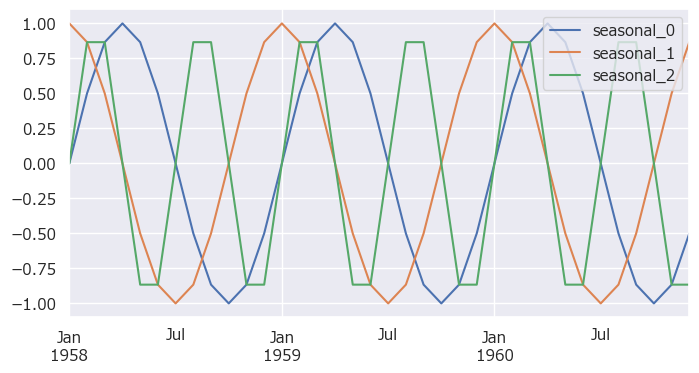

In [35]:
# 参考：周期性を表現する特徴量
x_test.iloc[:, 1:4].plot()

#### モデルの推定

In [36]:
# 前処理
transed = detrend.fit_transform(train_air)

# モデル化
gbm_reg = lgb.LGBMRegressor(**params_3)

# モデルの当てはめ
gbm_reg.fit(x_train, transed)

LGBMRegressor(learning_rate=0.07, min_data_in_leaf=4, num_leaves=60,
              objective='regression', seed=1, verbose=-1)

In [37]:
# 予測の実施
pred_gbm_reg = pd.DataFrame(
    {'value':gbm_reg.predict(x_test)}, index=test_air.index)

# 変換をもとに戻す
pred_gbm_reg = detrend.inverse_transform(pred_gbm_reg)

In [38]:
# 予測精度
mae = mean_absolute_error(test_air, pred_gbm_reg)
mase = mean_absolute_scaled_error(
    test_air, pred_gbm_reg, y_train=train_air)

print('MAE :', mae)
print('MASE:', mase)

MAE : 18.040878836888798
MASE: 0.887936538890111


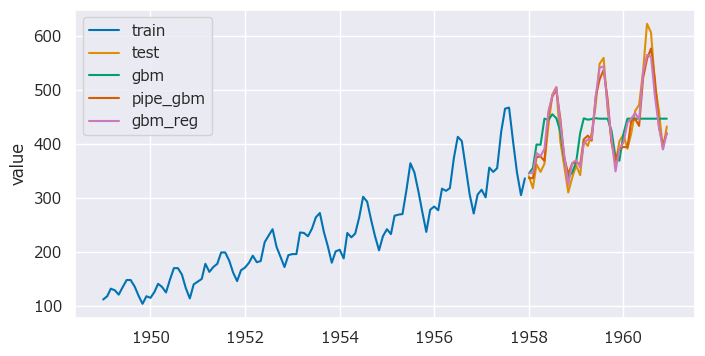

In [39]:
# 予測結果の可視化
fig, ax = plot_series(train_air, test_air, 
                      gbm_pred_air, pipe_gbm_pred, pred_gbm_reg,
                      labels=['train', 'test', 'gbm', 'pipe_gbm', 'gbm_reg'], 
                      markers=np.tile('', 5))
fig.set_size_inches(8, 4)